In [1]:
# MIT image
# Made by : HERO Kwon
# Date : 190108

import os
import numpy as np
import pandas as pd
import pickle
import gzip
import matplotlib.pyplot as plt
import math
import cmath

# data path
#path_meta = '/home/herokwon/mount_data/Data/Wi-Fi_meta/'
#path_csi = '/home/herokwon/mount_data/Data/Wi-Fi_processed/'
#path_csi_np = '/home/herokwon/mount_data/Data/Wi-Fi_processed_npy/'

# data path_mi
path_csi = 'D:\\Data\\Wi-Fi_processed\\'
path_csi_np = 'D:\\Data\\Wi-Fi_processed_npy\\'
path_meta = 'D:\\Data\\Wi-Fi_meta\\'

# data info
df_info = pd.read_csv(path_meta+'data_subc_sig_v1.csv')
df_info = df_info[df_info.id_person==107]
person_uid = np.unique(df_info['id_person'])
dict_id = dict(zip(person_uid,np.arange(len(person_uid))))
csi_time = 15000 #int(np.max(df_info['len']))
# parameters
max_value = np.max(df_info['max'].values)
#no_classes = len(np.unique(df_info['id_person']))
no_classes = len(dict_id)
csi_subc = 3
input_shape = (csi_time, csi_subc, 6)

# freq BW list
bw_list = pd.read_csv(path_meta+'wifi_f_bw_list.csv')

# avg Array
with open(path_meta + 'dict_avgcsi.pickle','rb') as f:
    dict_avg = pickle.load(f)


# make data generator
def gen_csi(df_info,dict_avg,id_num,len_num):
    for file in np.unique(df_info.id.values):
        # read sample data
        # load and uncompress.
        with gzip.open(path_csi+file+'.pickle.gz','rb') as f:
            data1 = pickle.load(f)
        data1_diff = data1 #np.diff(data1,axis=0)
        # zero pad
        pad_len = len_num - data1_diff.shape[0]
        data1_pad = np.pad(data1_diff,((0,pad_len),(0,0),(0,0),(0,0)),'constant',constant_values=0)

        # Label
        id_key = df_info[df_info.id==file]['id_person'].values[0].astype('int')
        data1_y = dict_id[id_key]
        
        arr_avg = dict_avg[id_key][0]
        data1_result = data1_pad# - arr_avg
        
        yield(data1_result ,data1_y,id_key)

gen = gen_csi(df_info,dict_avg,no_classes,csi_time)
target_sig,target_lab,target_id = next(gen)


In [2]:
# 3D scan
m,n = 2,3
c =  299792458 # speed of light 
r = (160 + 160 + 164) * 0.01 # meter
#r = 1.64 #meter
d = 45 * 0.01 # meter
max_ch = 1#3
max_subc = 1

th_range,si_range = (30,30)
sig_mat = np.zeros([max_subc,csi_time,2*th_range,2*si_range])

In [3]:
# 3D Reconstruction func
from numba import vectorize
@vectorize(['complex128(complex128,float32,float32,int32,int32,\
float32,float32,float32,float32,int32,int32)'], target='cpu')
def Recon_3d(sig,theta,sigma,m,n,lam,d,k,r,t,c):
    above_eq1 = 1j * (2*math.pi) * k * r * t / c
    above_eq2 = 1j * (2*math.pi/lam) * math.sin(theta) * ((n+1)*d*math.cos(sigma) + (m+1)*d*math.sin(sigma))
    eq_res = sig* cmath.exp(above_eq1) * cmath.exp(above_eq2)
    return eq_res #math.atan2(eq_res.imag,eq_res.real)


In [4]:
import time
ti = time.time()
# Calc 3D
for subc in range(max_subc):
    sig1 = target_sig[:,subc,:,:]
    for idx_th,i in enumerate(range(-th_range,th_range)):
        for idx_si,j in enumerate(range(-si_range,si_range)):
            lam =  c*0.000001 / bw_list[str(subc)][8] #wavelength = 300 / frequency in MHz
            t = np.arange(1,csi_time+1,1,dtype=np.int32)
            k = 0.0
            theta = i * (np.radians(360)/2) / th_range
            sigma = j * (np.radians(360)/2) / si_range
            sum_eq = np.zeros(csi_time,dtype=np.complex_)
            for m in [0]: 
                for n in [0,1,2]: 
                    #above_eq1 = Calc_Above1(k,r,t,c)
                    sig1 = np.ascontiguousarray(target_sig[:,subc,m,n], dtype=np.complex128)
                    sum_eq += Recon_3d(sig1,theta,sigma,m,n,lam,d,k,r,t,c)
            sig_mat[subc,:,idx_th,idx_si] =  np.angle(sum_eq)
    
print(time.time()-ti)

14.617335319519043


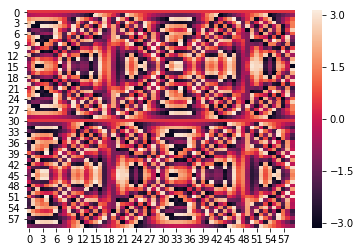

In [5]:
import seaborn as sns
ax = sns.heatmap(sig_mat[0,10,:2*th_range,:2*si_range])#,vmin=np.median(sig_mat))


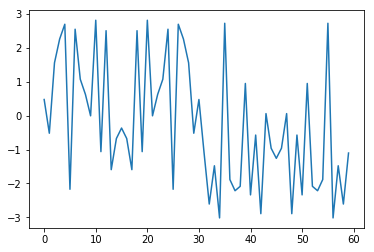

In [6]:
plt.plot(sig_mat[0,10,:2*th_range,0])

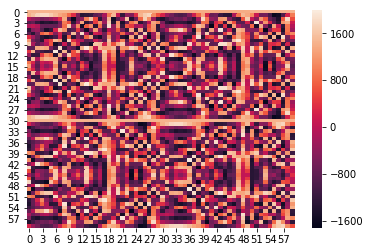

In [7]:
sig_sum = np.sum(sig_mat,axis=(0,1))
ax = sns.heatmap(sig_sum[:2*th_range,:2*si_range])#,vmin=np.median(sig_mat))

In [8]:
bw_list

,Channel,F0 (MHz),BW,range0,range1,0,1,2,3,4,...,20,21,22,23,24,25,26,27,28,29
0,1,2412,22,2401,2423,2401.733333,2402.466667,2403.2,2403.933333,2404.666667,...,2416.4,2417.133333,2417.866667,2418.6,2419.333333,2420.066667,2420.8,2421.533333,2422.266667,2423
1,2,2417,22,2406,2428,2406.733333,2407.466667,2408.2,2408.933333,2409.666667,...,2421.4,2422.133333,2422.866667,2423.6,2424.333333,2425.066667,2425.8,2426.533333,2427.266667,2428
2,3,2422,22,2411,2433,2411.733333,2412.466667,2413.2,2413.933333,2414.666667,...,2426.4,2427.133333,2427.866667,2428.6,2429.333333,2430.066667,2430.8,2431.533333,2432.266667,2433
3,4,2427,22,2416,2438,2416.733333,2417.466667,2418.2,2418.933333,2419.666667,...,2431.4,2432.133333,2432.866667,2433.6,2434.333333,2435.066667,2435.8,2436.533333,2437.266667,2438
4,5,2432,22,2421,2443,2421.733333,2422.466667,2423.2,2423.933333,2424.666667,...,2436.4,2437.133333,2437.866667,2438.6,2439.333333,2440.066667,2440.8,2441.533333,2442.266667,2443
5,6,2437,22,2426,2448,2426.733333,2427.466667,2428.2,2428.933333,2429.666667,...,2441.4,2442.133333,2442.866667,2443.6,2444.333333,2445.066667,2445.8,2446.533333,2447.266667,2448
6,7,2442,22,2431,2453,2431.733333,2432.466667,2433.2,2433.933333,2434.666667,...,2446.4,2447.133333,2447.866667,2448.6,2449.333333,2450.066667,2450.8,2451.533333,2452.266667,2453
7,8,2447,22,2436,2458,2436.733333,2437.466667,2438.2,2438.933333,2439.666667,...,2451.4,2452.133333,2452.866667,2453.6,2454.333333,2455.066667,2455.8,2456.533333,2457.266667,2458
8,9,2452,22,2441,2463,2441.733333,2442.466667,2443.2,2443.933333,2444.666667,...,2456.4,2457.133333,2457.866667,2458.6,2459.333333,2460.066667,2460.8,2461.533333,2462.266667,2463
9,10,2457,22,2446,2468,2446.733333,2447.466667,2448.2,2448.933333,2449.666667,...,2461.4,2462.133333,2462.866667,2463.6,2464.333333,2465.066667,2465.8,2466.533333,2467.266667,2468


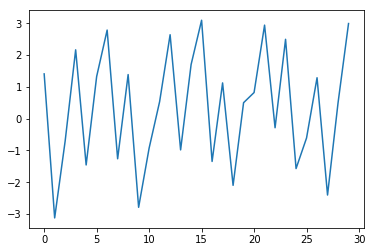

In [40]:
aa = np.angle(target_sig[10,:,0,0])
plt.plot(aa)

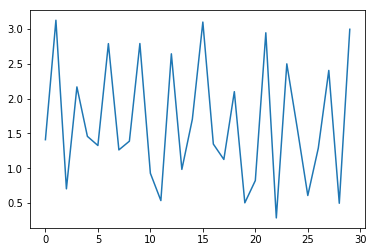

In [41]:
plt.plot(np.abs(aa))

In [11]:
aa = np.angle(a)

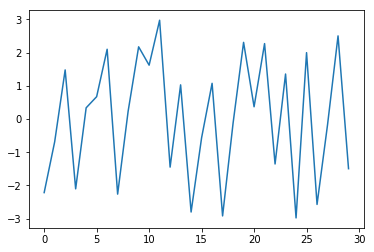

In [12]:
plt.plot(aa)

In [13]:
0.886* lam / 0.9

0.12086865333563616

In [43]:
np.unique(df_info.id.values)

array(['S107_1_1_1', 'S107_1_1_10', 'S107_1_1_11', 'S107_1_1_12',
       'S107_1_1_13', 'S107_1_1_2', 'S107_1_1_4', 'S107_1_1_5',
       'S107_1_1_6', 'S107_1_1_9', 'S107_1_2_1', 'S107_1_2_10',
       'S107_1_2_12', 'S107_1_2_13', 'S107_1_2_2', 'S107_1_2_3',
       'S107_1_2_4', 'S107_1_2_5', 'S107_1_2_6', 'S107_1_2_7',
       'S107_1_2_9', 'S107_1_3_1', 'S107_1_3_10', 'S107_1_3_12',
       'S107_1_3_2', 'S107_1_3_3', 'S107_1_3_4', 'S107_1_3_5',
       'S107_1_3_6', 'S107_1_3_7', 'S107_1_3_8', 'S107_1_3_9',
       'S107_1_4_1', 'S107_1_4_10', 'S107_1_4_11', 'S107_1_4_12',
       'S107_1_4_2', 'S107_1_4_3', 'S107_1_4_4', 'S107_1_4_5',
       'S107_1_4_6', 'S107_1_4_7', 'S107_1_4_8', 'S107_1_4_9',
       'S107_2_1_1', 'S107_2_1_10', 'S107_2_1_11', 'S107_2_1_12',
       'S107_2_1_13', 'S107_2_1_2', 'S107_2_1_3', 'S107_2_1_4',
       'S107_2_1_5', 'S107_2_1_6', 'S107_2_1_7', 'S107_2_1_8',
       'S107_2_1_9', 'S107_2_2_2', 'S107_2_2_3', 'S107_2_2_5',
       'S107_2_2_6', 'S107_2_4_11', 'S1